(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [1]:
'''
thought: calc the score using text words and arrange the users from lower
score to higher score.  Then plot their calculated score and 
actual rating(star).  It should match in trend(both growing or decreasing)
'''
from nltk.stem.porter import PorterStemmer
import pandas as pd
from pandas import DataFrame
import numpy as np
import unicodedata
import json
import csv
import os

porter = PorterStemmer()

reviewFile = open(
        './yelp_dataset/yelp_academic_dataset_review.json',
        'r'
)

lexion_pos = open(
    './positive-words.txt',
    'r'
)

lexion_neg = open(
    './negative-words.txt',
    'r'
)

pos_lst = np.array([])
neg_lst = np.array([])

for line in lexion_pos:
    if line[0] is not ';':
        pos_lst = np.append(pos_lst, line[:-1])
    else:
        pass
    
for line in lexion_neg:
    if line[0] is not ';':
        neg_lst = np.append(neg_lst, line[:-1])
    else:
        pass

print pos_lst
print neg_lst

['' 'a+' 'abound' ..., 'zenith' 'zest' 'zippy']
['' '2-faced' '2-faces' ..., 'zealous' 'zealously' 'zombie']


In [12]:
#readfile by line and calc score, save to a dataframe
import time


def calc_line(review_string, print_bool):
    start_time = time.time()
    review_score = 0.0
#     porter = PorterStemmer()
#     review_string = porter.stem(review_string)
    review_string = unicodedata.normalize('NFKD', review_string).encode('ascii','ignore').lower()
    review_token_lst = whitespace_tokenize(review_string)
    if print_bool:
        time1 = time.time()
        print '    2.1: ' + str(time1 - start_time)
    pos_words = np.intersect1d(review_token_lst, pos_lst)
    neg_words = np.intersect1d(review_token_lst, neg_lst)
    review_score = review_score + len(pos_words) - len(neg_words)
    if print_bool:
        time2 = time.time()
        print '    2.2: ' + str(time2 - time1)
    #normalize to 0~5
    if len(pos_words) + len(neg_words) is not 0:
        review_score = (review_score * 2.5) / (1.0 * len(pos_words) + len(neg_words)) + 2.5
    else:
        review_score = 0
    del(pos_words)
    del(neg_words)
    if print_bool:
        time3 = time.time()
        print '    2.3: ' + str(time3 - time2)
        print '    --------------------------'
    return review_score

def whitespace_tokenize(review_string):
#     token_lst = ['!', '.', ',', '?']
#     for token in token_lst:
#         review_string = review_string.replace(token , '')
    review_token_lst = review_string.split(' ')
    return np.array(review_token_lst)
    
def calc_score(reviewFile):
    #open file
    os.system("rm score_dataframe.csv")
    os.system("touch score_dataframe.csv")
    score_df = open('score_dataframe.csv', 'r+b')
    #create header
    columns = ['review_id','star','calculated_id']

    writerFile = csv.writer(score_df, delimiter=',')
    writerFile.writerow(columns)
    
    start_time = time.time()
    one_k_time = time.time()
    scoreDF = DataFrame(columns = [
        'review_id', 
        'stars', 
        'calcuated_score'
        ])
    i = 0
#     star_lst = np.array([])
#     review_score_lst = np.array([])
    for line in reviewFile:
        start_time = time.time()
        i = i + 1
        json_dict = json.loads(line)
        review_id = json_dict['review_id']
        stars = json_dict['stars']
        review_string = json_dict['text']
#         if i % 1000 == 0:
#             time1 = time.time()
#             print '1: ' + str(time1 - start_time)
        #calc score for line
#         if i % 1000 == 0:
#             review_score = calc_line(review_string, True)
#         else:
#             review_score = calc_line(review_string, False)
        review_score = calc_line(review_string, False)
#         if i % 1000 == 0:
#             time2 = time.time()
#             print '2: ' + str(time2 - time1)
        
        #write to df 
        writerFile.writerow([review_id, stars, review_score])
#         if i % 1000 == 0:
#             time3 = time.time()
#             print '3: ' + str(time3 - time2)
#             print '============================'
        if i % 10000 == 0:
            print i / 1000
            print time.time() - one_k_time
            one_k_time = time.time()
    #sort df by calculated_score

In [13]:
calc_score(reviewFile)

10
12.0723628998
20
11.4736378193
30
11.7150018215
40
12.0594849586
50
11.1718559265
60
11.0631411076
70
11.052241087
80
11.1083509922
90
11.0958170891
100
11.1462891102
110
11.0465679169
120
11.1038839817
130
11.1096689701
140
11.0831589699
150
11.0582838058
160
11.0679159164
170
11.0343420506
180
11.1505961418
190
11.127502203
200
11.1480660439
210
11.1716489792
220
11.1392791271
230
11.1258420944
240
11.1158978939
250
11.1019561291
260
11.0721268654
270
11.1245172024
280
11.1976668835
290
11.1054451466
300
11.2564458847
310
11.2883780003
320
11.2019851208
330
11.296875
340
11.1430089474
350
11.188352108
360
11.1748418808
370
11.1756770611
380
11.1913249493
390
11.1429240704
400
11.2966339588
410
11.2685110569
420
11.4098789692
430
11.48488307
440
11.6417791843
450
11.7400708199
460
11.8032290936
470
11.8921039104
480
11.553565979
490
11.2892620564
500
11.2123839855
510
11.1954789162
520
11.1302011013
530
11.0641520023
540
11.0601069927
550
11.0863819122
560
11.068007946
570
11.08239

Visualization and short (detailed) analysis. **(10 pts)**

In [1]:
#read both dataframe and visualize
import pandas as pd
review_df = pd.read_csv('./score_dataframe.csv')

In [2]:
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def plotSeries(series, series2):
    plt.figure(figsize=(20,10))
    plt.plot(series)
#     plt.plot(series2)
    plt.xlabel('id')
    plt.ylabel('star')


In [4]:
review_df = review_df.sort(['star', 'calculated_id'], ascending=[1 , 1])

/Users/Gladius/anaconda2/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


(0, 5)

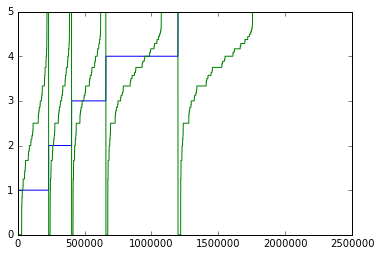

In [5]:
# star_series = review_df['star']
# score_series = review_df['calculated_id']
# review_df.star.plot(label='star', linewidth=2)
star = np.array(review_df.star.values)
score = np.array(review_df.calculated_id.values)
plt.plot(star)
plt.plot(score)
plt.ylim(0 , 5)

For most of posts that gives 5 stars, the calculated score is 5.  The score we got from sentiment analysis here is actually the ratio of pos word and neg words.  In those reviews that has 5 stars and 5 calculated scores, there must be no negative words in the review text.  However there might be negation works like "not bad" but the bad is calculated as a negative word so there might be cases that people give 5 stars and we got like 3 or 4 calculated scores.  Also there might be people giving 1 or two stars but has a pretty high score, sometimes even 5, in this case negation is also a possible answer, and some people prefer not to use too much negative words, instead they might use "they lost my business for good" in which good might be considered a positive word.

-----------------

Now, let's look at Business Objects. Try to find **culinary districts in Las Vegas**. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to **cluster closeness**. Use "categories" and "attributes" to **cluster for similarity**.

Find clusters using the 3 different techniques we discussed in class: **k-means++**, **hierarchical**, and **GMM**. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The **spatial coordinates** and **restaurant categories/attributes** have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

In [15]:
import json
#open file
business_file = open("/Users/Gladius/Downloads/yelp\
_dataset_challenge_academic_dat\
aset/yelp_academic_dataset_business.json",'r')

In [12]:
#get data filtered
def get_restaurants():
    i = 0
    for line in business_file:
        tempDict = json.loads(line)
        if tempDict['city'] == u'Las Vegas':
            if u'Restaurants' in tempDict['categories']:
                #save it somewhere, maybe df?
                pass


Visualize your clusters using **each technique**. Label your clusters. **(10 pts)**

Now let's **detect outliers**. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()